In [1]:
from sklearn.datasets import make_regression, load_boston
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from cvxopt import matrix
from cvxopt import solvers
from numpy import linalg as LA
from sklearn.preprocessing import StandardScaler

In [2]:
X = 2 - 3 * np.random.normal(0, 1, 1000)
y = X - 2 * (X ** 2) + 0.5 * (X ** 3) + np.random.normal(-3, 3, 1000)

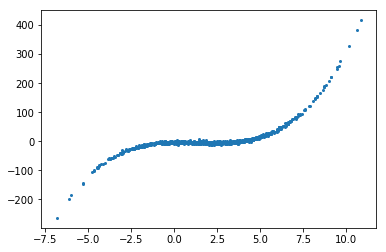

In [3]:
'''X, y = load_boston(return_X_y=True)
X = X[:, -1]'''
X = np.expand_dims(X, axis=1)
seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
plt.scatter(X_train, y_train, s=4)
plt.show()

## Neural tangent kernel + random fourier features

In [4]:
def gaussian_fourier(w):
    return (2*np.pi)**(-w.shape[0]/2) * np.exp(-LA.norm(w)/2)

def laplacian_fourier(w):
    p = 1
    for i in range(w.shape[0]):
        p *= 1 / (np.pi * (1 + w[i]))
    return p

def metropolis_hastings(p, dim, iter=1000):
    x = np.zeros(dim)
    samples = np.zeros((iter, dim))

    for i in range(iter):
        x_next = x + np.random.multivariate_normal(np.zeros(dim), np.eye(dim))
        if np.random.rand() < p(x_next) / p(x):
            x = x_next
        samples[i] = x

    return samples

def _feature_mapping(X, omega, bias, D):
    X_map = np.zeros((X.shape[0], D))
    for i in range(X.shape[0]):
        for j in range(D):
            X_map[i, j] = np.cos(np.dot(omega[j], X[i]) + bias[j]) * np.sqrt(2/D)
    return X_map

def _draw_features(d, D, func, max_iter=1000):
    s = metropolis_hastings(func, dim=d, iter=max_iter)
    omega = s[np.random.randint(low=10, high=max_iter, size=D)]
    bias = np.random.uniform(low=0, high=2*np.pi, size=D)
    return omega, bias

In [5]:
d = 1
D = 10
omega, bias = _draw_features(d, D, gaussian_fourier)
X_train_map = _feature_mapping(X_train, omega, bias, D)
X_test_map = _feature_mapping(X_test, omega, bias, D)

In [6]:
def NTK(x1, x2):
    temp = np.dot(x1.T, x2) / (LA.norm(x1) * LA.norm(x2))
    if temp > 1.:
        temp = 1.
    if temp < -1.:
        temp = -1.
    return np.dot(x1.T, x2) * (np.pi - np.arccos(temp)) / (2 * np.pi)

In [7]:
m,n = X_train_map.shape
K = np.zeros((m, m))
for i, x_i in enumerate(X_train_map):
    for j, x_j in enumerate(X_train_map):
        K[i, j] = NTK(x_i, x_j)
K

array([[ 0.62688817,  0.16617303,  0.10732899, ..., -0.0337489 ,
         0.04385173, -0.07812245],
       [ 0.16617303,  0.63464375,  0.50683804, ...,  0.03237614,
        -0.01240358, -0.07898402],
       [ 0.10732899,  0.50683804,  0.55722163, ...,  0.09059654,
        -0.04290597, -0.06819506],
       ...,
       [-0.0337489 ,  0.03237614,  0.09059654, ...,  0.47724393,
        -0.08992954,  0.05240993],
       [ 0.04385173, -0.01240358, -0.04290597, ..., -0.08992954,
         0.5802106 ,  0.17648073],
       [-0.07812245, -0.07898402, -0.06819506, ...,  0.05240993,
         0.17648073,  0.56246382]])

In [8]:
pred_mtx = np.zeros(m)
pred = []
for x in X_test_map:
    for x_i, i in zip(X_train_map, range(m)):
        pred_mtx[i] = NTK(x, x_i)
    pred.append(np.dot(pred_mtx, np.dot(LA.inv(K), y_train)))
pred = np.array(pred)

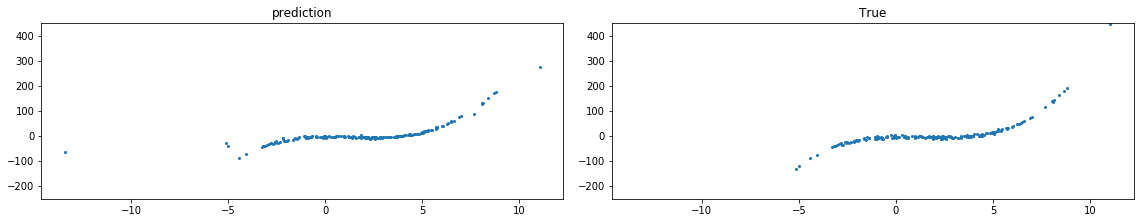

In [14]:
fig = plt.figure(figsize=plt.figaspect(0.2))
ax = fig.add_subplot(121)
ax.scatter(X_test[:, 0], pred, s=4)
ax.set_ylim([-250, 450])
plt.title("prediction")
ax = fig.add_subplot(122)
ax.scatter(X_test[:, 0], y_test, s=4)
ax.set_ylim([-250, 450])
plt.title("True")
plt.tight_layout()
plt.show()